In [9]:
import os
import numpy as np

import torch
import torchvision
from torchvision import models, datasets, transforms
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.cuda import amp  
from sklearn.metrics import classification_report, confusion_matrix
import random 

from PIL import Image

In [10]:
import shutil

# Path for dataset
data_p = '/kaggle/input/covid-19-radiography-dataset'

# Covid and Non-Covid
covid_dir = os.path.join(data_p, 'COVID')
lung_opacity_dir = os.path.join(data_p, 'Lung_Opacity')
normal_dir = os.path.join(data_p, 'Normal')
viral_pneumonia_dir = os.path.join(data_p, 'Viral Pneumonia')


# For storing train and Val set (80/20)
train_covid_dir = '/kaggle/working/train/COVID'
val_covid_dir = '/kaggle/working/val/COVID'
train_lung_opacity_dir = '/kaggle/working/train/Lung_Opacity'
val_lung_opacity_dir = '/kaggle/working/val/Lung_Opacity'
train_normal_dir = '/kaggle/working/train/Normal'
val_normal_dir = '/kaggle/working/val/Normal'
train_viral_pneumonia_dir ='/kaggle/working/train/Viral Pneumonia'
val_viral_pneumonia_dir ='/kaggle/working/val/Viral Pneumonia'

# making Directories
os.makedirs(train_covid_dir, exist_ok=True)
os.makedirs(val_covid_dir, exist_ok=True)
os.makedirs(train_lung_opacity_dir, exist_ok=True)
os.makedirs(val_lung_opacity_dir, exist_ok=True)
os.makedirs(train_normal_dir, exist_ok=True)
os.makedirs(val_normal_dir, exist_ok=True)
os.makedirs(train_viral_pneumonia_dir, exist_ok=True)
os.makedirs(val_viral_pneumonia_dir, exist_ok=True)


def split_dataset(source_dir, train_dir, val_dir, split_ratio=0.8):
    all_files = os.listdir(source_dir)
    random.shuffle(all_files)
    split_idx = int(len(all_files) * split_ratio)
    train_files = all_files[:split_idx]
    val_files = all_files[split_idx:]
    for file in train_files:
        shutil.copy2(os.path.join(source_dir, file), os.path.join(train_dir, file))

    for file in val_files:
        shutil.copy2(os.path.join(source_dir, file), os.path.join(val_dir, file))

split_dataset(covid_dir, train_covid_dir, val_covid_dir)
split_dataset(lung_opacity_dir, train_lung_opacity_dir, val_lung_opacity_dir)
split_dataset(normal_dir, train_normal_dir, val_normal_dir)
split_dataset(viral_pneumonia_dir, train_viral_pneumonia_dir, val_viral_pneumonia_dir)
print("Splitting Complete")

Splitting Complete


In [11]:
!pip install dtcwt

In [12]:
import dtcwt
import numpy as np
from PIL import Image

# Dual-Tree Complex Wavelet Transform (Level - 1)
class DualTreeWaveletTransform:
    def __init__(self, level=1):
        self.level = level
        self.transform = dtcwt.Transform2d()

    def __call__(self, image, **kwargs):
        img_array = np.array(image)

        if img_array.ndim == 3:  # Process each color channel independently
            channel_images = [
                self.transform.forward(img_array[:, :, i], nlevels=self.level).lowpass

                for i in range(img_array.shape[2])
            ]

            img_array = np.stack(channel_images, axis=2)
        else:  # For grayscale images
            img_array = self.transform.forward(img_array, nlevels=self.level).lowpass

        img_pil = Image.fromarray(img_array.astype(np.uint8))
        return img_pil

In [13]:
#transformations for dataset
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    DualTreeWaveletTransform(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
# Load datasets
train_dataset = datasets.ImageFolder('/kaggle/working/train', transform=transform)
val_dataset = datasets.ImageFolder('/kaggle/working/val', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
val_dataset.__getitem__(5)[0].shape
torch.Size([3, 512, 512])
image = train_dataset.__getitem__(5)[0].permute(1, 2, 0).numpy()

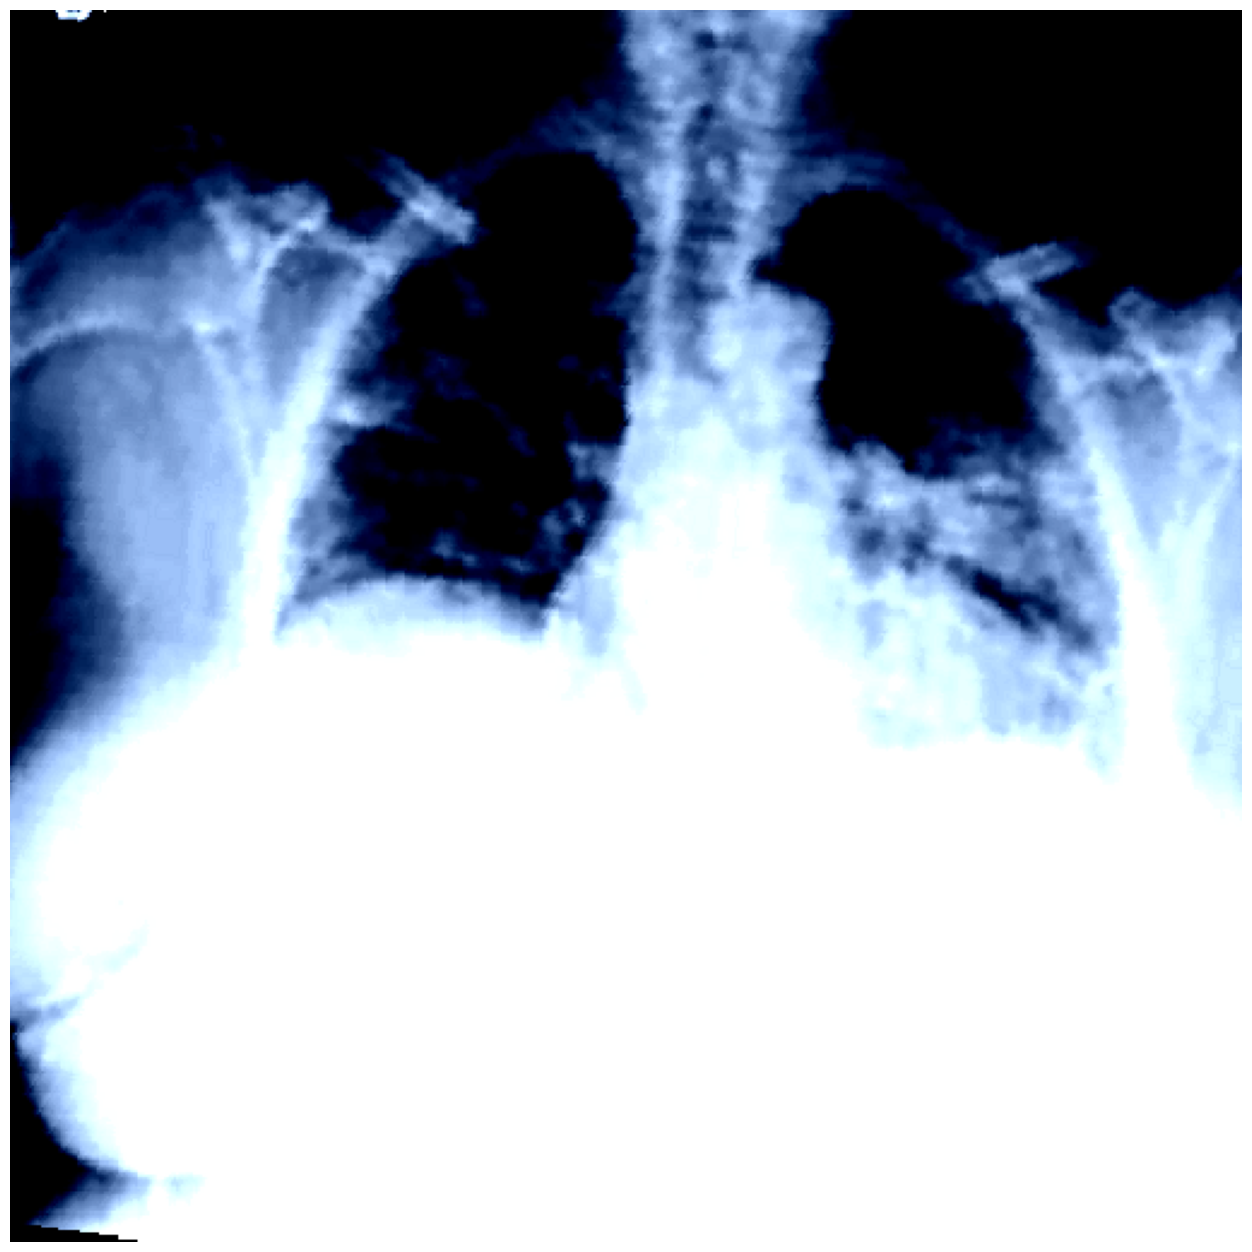

In [15]:
# Display wavelet applied image
plt.imshow(image)
plt.axis('off')  
plt.show()

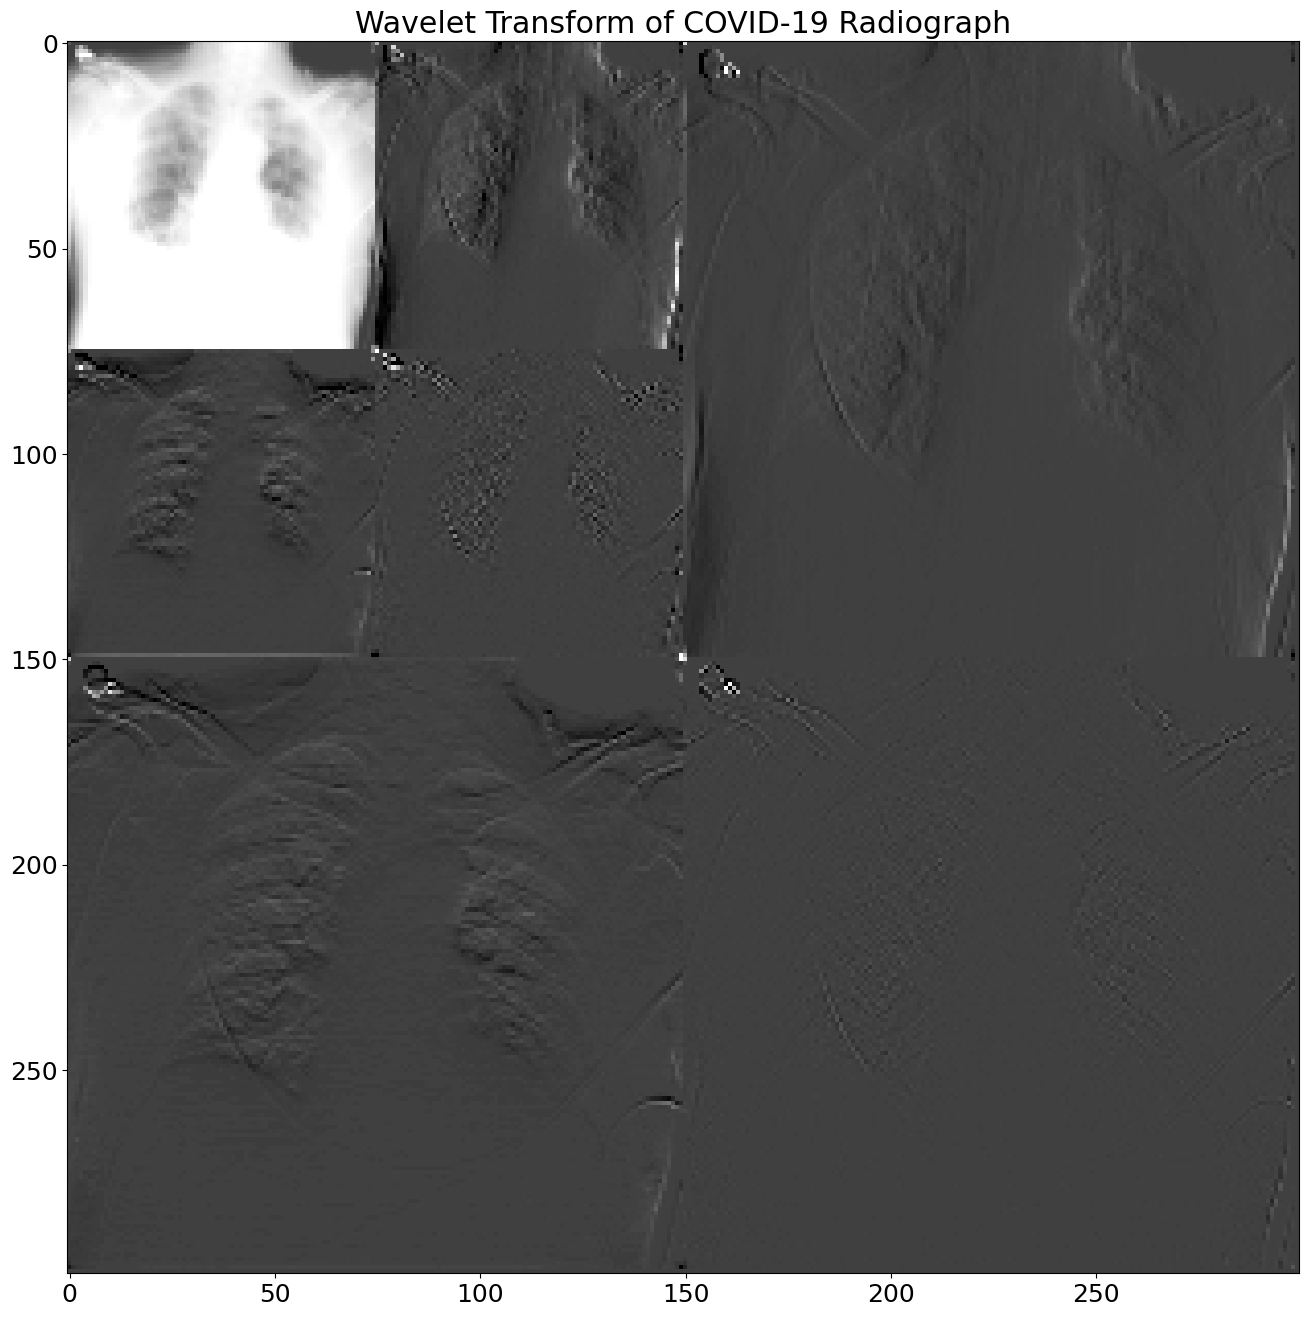

In [16]:
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import pywt
import os

plt.rcParams['figure.figsize'] = [16, 16]
plt.rcParams.update({'font.size': 18})

image_path = '/kaggle/input/covid-19-radiography-dataset/COVID/COVID-1.png'
A = imread(image_path)

# Convert RGB to grayscale if necessary
if A.ndim == 3:
    B = np.mean(A, axis=-1)
else:
    B = A  

n = 2
w = 'db1'
coeffs = pywt.wavedec2(B, wavelet=w, level=n)

# Normalize each coefficient array
coeffs[0] /= np.abs(coeffs[0]).max()
for detail_level in range(n):
    coeffs[detail_level + 1] = [d / np.abs(d).max() for d in coeffs[detail_level + 1]]

arr, coeff_slices = pywt.coeffs_to_array(coeffs)

plt.imshow(arr, cmap='gray', vmin=-0.25, vmax=0.75)
plt.title("Wavelet Transform of COVID-19 Radiograph")
plt.show()